<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc" style="margin-top: 1em;"><ul class="toc-item"></ul></div>

In [1]:
push!(LOAD_PATH, ".")
using RobustOptimization
using Ipopt, JuMP, PyPlot
using ScikitLearn
@sk_import model_selection: train_test_split
@sk_import metrics: roc_curve
@sk_import metrics: roc_auc_score
path_train = "datasets/a1a"
path_test = "datasets/a1a.t"
nbfeatures = 123
df_train = read_data_libsvm(path_train, nbfeatures)
df_test = read_data_libsvm(path_test, nbfeatures);
# df_train, df_aux = create_data("w8a", nbfeatures, 0.1, train_test_split);

In [11]:
solver = IpoptSolver(print_level = 0)
N = size(df_train)[1]
ϵ = 0.1
verbosity = 1
itmax = 100
sample = 900

ambiguity = "KLdivergence"
robustModel = RobustModel(N, nbfeatures, ϵ, ambiguity, LogisticRegression())
α = 1/norm(robustModel.descent_direction)
projParams = ProjParams(Int(50), 1e-5, sample, para_proj=Sequential(), para_inter=Sequential())
optParams = OptParams(itmax, 1e-5, α, verbosity = verbosity);

In [3]:
xnormal = normal_opt(df_train, solver, robustModel.regressionModel)
fpr, tpr, thresholds = roc_curve(df_test[:,end], positive_rate(xnormal,df_test))


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************



([0.0, 0.000850702, 0.000850702, 0.000893237, 0.000893237, 0.000935772, 0.000935772, 0.00102084, 0.00102084, 0.00106338  …  0.996214, 0.997193, 0.997278, 0.997788, 0.997788, 0.999532, 0.999532, 0.99966, 0.99966, 1.0], [0.0, 0.000805802, 0.000940102, 0.000940102, 0.0020145, 0.0020145, 0.00308891, 0.00308891, 0.00322321, 0.00322321  …  0.999597, 0.999597, 0.999597, 0.999597, 0.999731, 0.999731, 0.999866, 0.999866, 1.0, 1.0], [2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0  …  1.21531e-27, 1.5317e-30, 1.4777e-30, 2.32041e-31, 2.22527e-31, 9.15303e-38, 8.79572e-38, 4.19409e-38, 2.76832e-38, 3.41283e-48])

In [12]:
dm_tab = []
xr1_tab = []
xr2_tab = []
fpr1_tab = []
tpr1_tab = []
fpr2_tab = []
tpr2_tab = []
for ϵ in [0.001,0.005,0.01,0.05,0.1,0.5,1.0]
    println(" ")
    println("espilon = ", ϵ)
    println(" ")
    robustModel = RobustModel(N, nbfeatures, ϵ, ambiguity, LogisticRegression())
    x0 = ones(robustModel.descent_direction)
    xalg, yalg, dm, mem, mini = run_algo(x0, df_train, robustModel, optParams, projParams)
    xrobust1 = getsolution(xalg, ambiguity, nbfeatures)
    xrobust2 = getsolution(mem, ambiguity, nbfeatures)
    fpr1, tpr1, thresholds = roc_curve(df_test[:,end], positive_rate(xrobust1,df_test))
    fpr2, tpr2, thresholds = roc_curve(df_test[:,end], positive_rate(xrobust2,df_test))
    push!(dm_tab, dm)
    push!(xr1_tab, xrobust1)
    push!(xr2_tab, xrobust2)
    push!(fpr1_tab, fpr1)
    push!(tpr1_tab, tpr1)
    push!(fpr2_tab, fpr2)
    push!(tpr2_tab, tpr2)
end

 
espilon = 0.001
 
1 0.4463775701287993 2 0.04441673776012234 3 0.02421471482168558 4 0.08295273288065963 5 0.1242591027463138 6 0.11948185595882088 7 0.1383653810156782 8 0.18441677976322124 9 0.1621515657784358 10 0.07096216516614451 11 0.12744589079789503 12 0.17630353213748506 13 0.13802125074966454 14 0.1740074053409122 15 0.07786319209303527 16 0.09908285994167398 17 0.07081064297024642 18 0.0675246169513748 19 0.061183713653835126 20 0.12876901616333924 21 0.06612896515530986 22 0.0738109663726434 23 0.07150082384661749 24 0.17313435827855628 25 0.08635421731737192 26 0.10494952402347946 27 0.11323364769638311 28 0.06115924369407044 29 0.05806343975398076 30 0.07796703200636235 31 0.0490674010648422 32 0.042564403668497786 33 0.08905882391306497 34 0.07690281379570485 35 0.03178926360379264 36 0.0768330944956872 37 0.11707376803440872 38 0.1265235784810519 39 0.11111006499078258 40 0.12085627340090088 41 0.11142598141946558 42 0.16662089522703027 43 0.08280467978632355 44 0.156

LoadError: [91mInterruptException:[39m

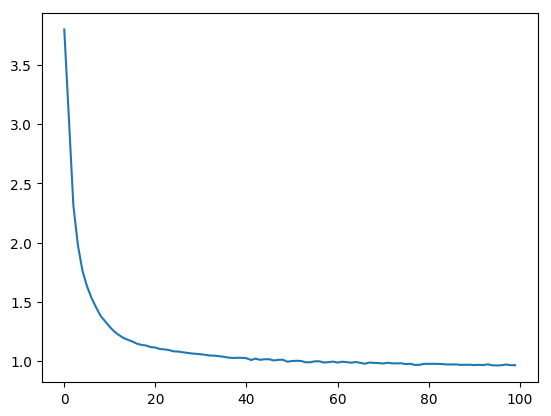

In [18]:
for i in 1:7
     plot(dm_tab[i])
end

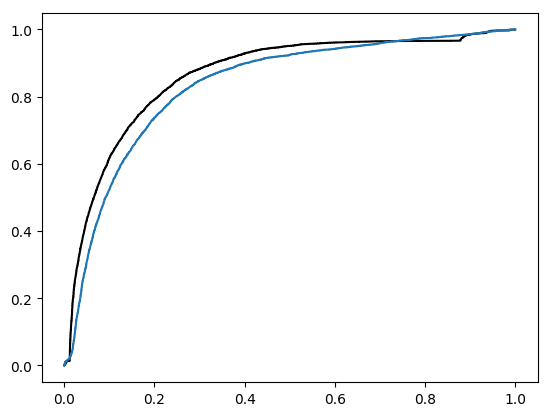

In [19]:
plot(fpr,tpr, color="black")
for i in 1:1
     plot(fpr1_tab[i], tpr1_tab[i])
end

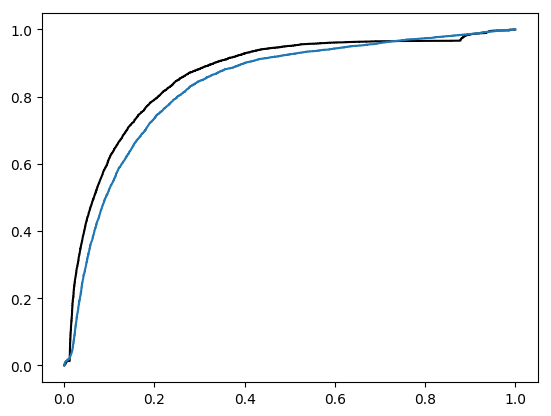

In [20]:
plot(fpr,tpr, color="black")
for i in 1:1
     plot(fpr2_tab[i], tpr2_tab[i])
end

In [21]:
println(roc_auc_score(df_test[:,end], positive_rate(xnormal,df_test)))
for i in 1:1
    println(roc_auc_score(df_test[:,end], positive_rate(xr1_tab[i],df_test)))
end

0.8635111609772126
0.8334689275044607


In [22]:
println(roc_auc_score(df_test[:,end], positive_rate(xnormal,df_test)))
for i in 1:1
    println(roc_auc_score(df_test[:,end],positive_rate(xr2_tab[i],df_test)))
end

0.8635111609772126
0.833573208741961


In [10]:
open("a1a.txt", "w") do f
    write(f, "xnormal = ")
    write(f, "$xnormal \n")
    write(f, "fpr = ")
    write(f, "$fpr \n")
    write(f, "tpr = ")
    write(f, "$tpr \n")
    write(f, "dm_tab = ")
    write(f, "$dm_tab \n")
    write(f, "xr1_tab = ")
    write(f, "$xr1_tab \n")
    write(f, "fpr1_tab = ")
    write(f, "$fpr1_tab \n")
    write(f, "tpr1_tab = ")
    write(f, "$tpr1_tab \n")
end

730907

In [23]:
N = size(df_train)[1]
verbosity = 1
itmax = 500
sample = 128

ambiguity = "wasserstein"
robustModel = RobustModel(N, nbfeatures, ϵ, ambiguity, LogisticRegression())
α = 1/norm(robustModel.descent_direction)
# @everywhere α = 1.0
projParams = ProjParams(Int(100), 1e-5, sample, para_proj=Sequential(), para_inter=Sequential())
optParams = OptParams(itmax, 1e-5, α, verbosity = verbosity);

In [24]:
dm_was = []
xr1_was = []
xr2_was = []
fpr1_was = []
tpr1_was = []
fpr2_was = []
tpr2_was = []
for ϵ in [0.001,0.005,0.01,0.05,0.1,0.5,1.0]
# for ϵ in [0.001,0.005,0.01]
    println(" ")
    println("espilon = ", ϵ)
    println(" ")
    robustModel = RobustModel(N, nbfeatures, ϵ, ambiguity, LogisticRegression())
    x0 = init_proj(df_train, robustModel, projParams);
    xalg, yalg, dm, mem, mini = run_algo(x0, df_train, robustModel, optParams, projParams)
    xrobust1 = getsolution(xalg, ambiguity, nbfeatures)
    xrobust2 = getsolution(mem, ambiguity, nbfeatures)
    fpr1, tpr1, thresholds = roc_curve(df_aux[:,end], positive_rate(xrobust1,df_aux))
    fpr2, tpr2, thresholds = roc_curve(df_aux[:,end], positive_rate(xrobust2,df_aux))
    push!(dm_was, dm)
    push!(xr1_was, xrobust1)
    push!(xr2_was, xrobust2)
    push!(fpr1_was, fpr1)
    push!(tpr1_was, tpr1)
    push!(fpr2_was, fpr2)
    push!(tpr2_was, tpr2)
end

 
espilon = 0.001
 


LoadError: [91mInterruptException:[39m

In [ ]:
for i in 1:7
     plot(dm_was[i])
end

In [ ]:
plot(fpr,tpr, color="green")
for i in 1:7
     plot(fpr1_was[i], tpr1_was[i])
end

In [ ]:
plot(fpr,tpr, color="green")
for i in 1:7
     plot(fpr2_was[i], tpr2_was[i])
end

In [ ]:
println(roc_auc_score(df_aux[:,end], positive_rate(xnormal,df_aux)))
for i in 1:7
    println(roc_auc_score(df_aux[:,end],positive_rate(xr1_was[i],df_aux)))
end

In [ ]:
println(roc_auc_score(df_aux[:,end], positive_rate(xnormal,df_aux)))
for i in 1:7
    println(roc_auc_score(df_aux[:,end],positive_rate(xr2_was[i],df_aux)))
end